# Importing Libraries

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.backends.cudnn as cudnn
import numpy as np
import random
from torchsummary import summary
from tqdm.notebook import tqdm

import torchvision
import torchvision.transforms as transforms

import os

import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

# Configuration

In [ ]:
SEED = 42

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

BATCH_SIZE_TRAIN = 100
BATCH_SIZE_TEST = 100


transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261)),
])

# Creating Dataloaders

In [ ]:
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE_TRAIN, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=BATCH_SIZE_TEST, shuffle=False, num_workers=2)


classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


# Defining Models

In [ ]:
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(
            in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out

class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, in_planes, planes, stride=1):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, self.expansion *
                               planes, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(self.expansion*planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = F.relu(self.bn2(self.conv2(out)))
        out = self.bn3(self.conv3(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out

class ResNet50(nn.Module):
    def __init__(self, num_classes=10):
        super(ResNet50, self).__init__()
        self.in_planes = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(Bottleneck, 64, 3, stride=1)
        self.layer2 = self._make_layer(Bottleneck, 128, 4, stride=2)
        self.layer3 = self._make_layer(Bottleneck, 256, 6, stride=2)
        self.layer4 = self._make_layer(Bottleneck, 512, 3, stride=2)
        self.linear = nn.Linear(512 * Bottleneck.expansion, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        conv_feature_map = out
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out , conv_feature_map

class ResNetCustom(nn.Module):
    def __init__(self, num_classes=10):
        super(ResNetCustom, self).__init__()
        self.in_planes = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(BasicBlock, 44, 2, stride=1)
        self.layer2 = self._make_layer(BasicBlock, 128, 2, stride=2)
        self.layer3 = self._make_layer(BasicBlock, 256, 2, stride=2)
        self.layer4 = self._make_layer(Bottleneck, 256, 2, stride=2)
        self.linear = nn.Linear(256 * Bottleneck.expansion, num_classes)

        self.regressor = nn.Conv2d(1024, 2048, kernel_size=3, padding=1)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        regressor_input = out
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out , regressor_input

class DistillationModel(nn.Module):
    def __init__(self,student_model):
        super(DistillationModel, self).__init__()
        self.student = student_model
        self.regressor = nn.Conv2d(1024, 2048, kernel_size=3, padding=1)

    def forward(self, x):
        out, regressor_input = self.student(x)
        regressor_output = self.regressor(regressor_input)
        return out ,regressor_output

In [ ]:
teacher = ResNet50()
teacher = teacher.to(device)
summary(teacher, (3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
            Conv2d-3           [-1, 64, 32, 32]           4,096
       BatchNorm2d-4           [-1, 64, 32, 32]             128
            Conv2d-5           [-1, 64, 32, 32]          36,864
       BatchNorm2d-6           [-1, 64, 32, 32]             128
            Conv2d-7          [-1, 256, 32, 32]          16,384
       BatchNorm2d-8          [-1, 256, 32, 32]             512
            Conv2d-9          [-1, 256, 32, 32]          16,384
      BatchNorm2d-10          [-1, 256, 32, 32]             512
       Bottleneck-11          [-1, 256, 32, 32]               0
           Conv2d-12           [-1, 64, 32, 32]          16,384
      BatchNorm2d-13           [-1, 64, 32, 32]             128
           Conv2d-14           [-1, 64,

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(teacher.parameters(), lr=0.1,momentum=0.9,weight_decay=0.0005)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor= 0.1, patience= 3, threshold= 0.001, mode= 'max')

# Training the Teacher

In [ ]:
teacher_train_loss_history = []
teacher_train_accuracy_history = []

teacher_test_loss_history = []
teacher_test_accuracy_history = []

teacher_lowest_loss = float("inf")

In [ ]:
def train(epoch,model,trainloader,train_loss_history, train_accuracy_history):
    print('\nEpoch: %d' % epoch)
    model.train()
    train_loss = 0
    correct = 0
    total = 0
    pbar = tqdm(enumerate(trainloader),total=len(trainloader))
    for batch_idx,(inputs, targets) in pbar:
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs,_ = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()


        train_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()
        pbar.set_description("Training")
        pbar.set_postfix(loss=(train_loss/(batch_idx+1)), accuracy=(100*correct/total))

    train_loss_history.append(train_loss/len(trainloader))
    train_accuracy_history.append(correct/total)

In [ ]:
def test(epoch,model,scheduler,testloader,test_loss_history, test_accuracy_history):
    global teacher_lowest_loss
    model.eval()
    test_loss = 0
    correct = 0
    total = 0
    pbar = tqdm(enumerate(testloader),total=len(testloader))
    with torch.no_grad():
        for batch_idx, (inputs, targets) in pbar:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs,_ = model(inputs)
            loss = criterion(outputs, targets)

            test_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
            pbar.set_description("Evaluating")
            pbar.set_postfix(loss=(test_loss/(batch_idx+1)), accuracy=(100*correct/total))


    test_loss_history.append(test_loss/len(testloader))
    test_accuracy_history.append(correct/total)

    # Save checkpoint.
    curr_loss = test_loss/len(testloader)
    scheduler.step(curr_loss)
    if curr_loss < teacher_lowest_loss:
        print('Saving checkpoint..')
        if not os.path.isdir('/checkpoints'):
            os.mkdir('/checkpoints')
        torch.save(model.state_dict(), '/checkpoints/teacher_ckpt.pth')
        teacher_lowest_loss = curr_loss

In [ ]:
start_epoch = 0
n_epochs = 300
for epoch in range(start_epoch, start_epoch+n_epochs):
    train(epoch,teacher,trainloader,teacher_train_loss_history, teacher_train_accuracy_history)
    test(epoch,teacher,scheduler,testloader,teacher_test_loss_history, teacher_test_accuracy_history)


Epoch: 0


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Saving checkpoint..

Epoch: 1


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Saving checkpoint..


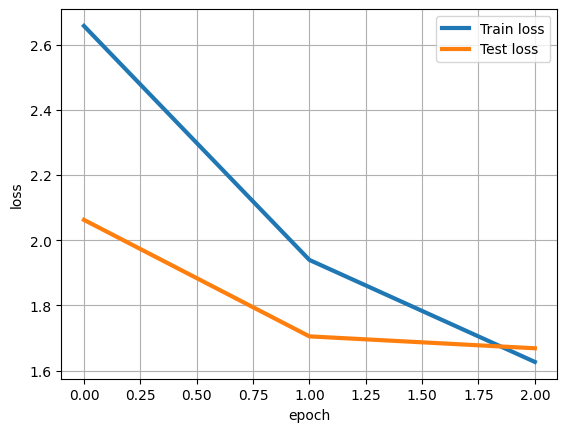

In [ ]:
plt.plot(range(len(teacher_train_loss_history)),teacher_train_loss_history,'-',linewidth=3,label='Train loss')
plt.plot(range(len(teacher_test_loss_history)),teacher_test_loss_history,'-',linewidth=3,label='Test loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.grid(True)
plt.legend()
plt.show()

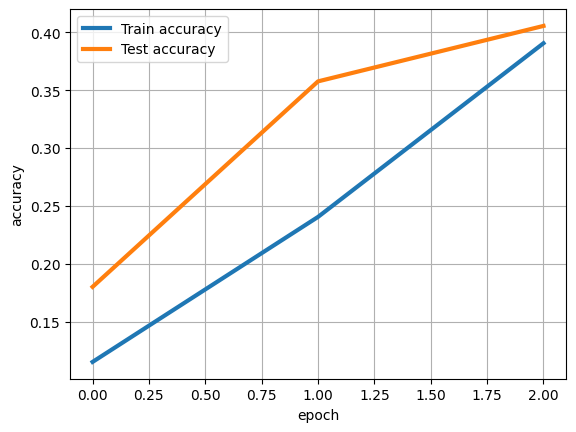

In [ ]:
plt.plot(range(len(teacher_train_accuracy_history)),teacher_train_accuracy_history,'-',linewidth=3,label='Train accuracy')
plt.plot(range(len(teacher_test_accuracy_history)),teacher_test_accuracy_history,'-',linewidth=3,label='Test accuracy')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.grid(True)
plt.legend()
plt.show()

# Training the Student

In [ ]:
train_loss_history = []
train_accuracy_history = []

test_loss_history = []
test_accuracy_history = []

lowest_loss = float("inf")

In [ ]:
teacher = ResNet50()
checkpoint = torch.load("/checkpoints/teacher_ckpt.pth")
teacher.load_state_dict(checkpoint)
teacher = teacher.to(device)

In [ ]:
student = ResNetCustom()
student = student.to(device)
summary(student, (3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
            Conv2d-3           [-1, 44, 32, 32]          25,344
       BatchNorm2d-4           [-1, 44, 32, 32]              88
            Conv2d-5           [-1, 44, 32, 32]          17,424
       BatchNorm2d-6           [-1, 44, 32, 32]              88
            Conv2d-7           [-1, 44, 32, 32]           2,816
       BatchNorm2d-8           [-1, 44, 32, 32]              88
        BasicBlock-9           [-1, 44, 32, 32]               0
           Conv2d-10           [-1, 44, 32, 32]          17,424
      BatchNorm2d-11           [-1, 44, 32, 32]              88
           Conv2d-12           [-1, 44, 32, 32]          17,424
      BatchNorm2d-13           [-1, 44, 32, 32]              88
       BasicBlock-14           [-1, 44,

In [ ]:
distillationmodel = DistillationModel(student)
distillationmodel = distillationmodel.to(device)
optimizer = optim.Adam(distillationmodel.parameters(), lr=0.001)

In [ ]:
def distillation_train(epoch,student,teacher,trainloader,train_loss_history, train_accuracy_history):
    ce_loss = nn.CrossEntropyLoss()
    mse_loss = nn.MSELoss()
    print('\nEpoch: %d' % epoch)

    teacher.eval()
    student.train()

    feature_map_weight = 0.25
    ce_loss_weight=0.75

    train_loss = 0
    correct = 0
    total = 0
    pbar = tqdm(enumerate(trainloader),total=len(trainloader))
    for batch_idx,(inputs, targets) in pbar:
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()

        with torch.no_grad():
            _, teacher_feature_map = teacher(inputs)

        student_logits, regressor_feature_map = student(inputs)

        # Calculate the loss
        hidden_rep_loss = mse_loss(regressor_feature_map, teacher_feature_map)

        # Calculate the true label loss
        label_loss = ce_loss(student_logits, targets)

        # Weighted sum of the two losses
        loss = feature_map_weight * hidden_rep_loss + ce_loss_weight * label_loss
        loss.backward()
        optimizer.step()


        train_loss += loss.item()
        _, predicted = student_logits.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()
        pbar.set_description("Training")
        pbar.set_postfix(loss=(train_loss/(batch_idx+1)), accuracy=(100*correct/total))

    train_loss_history.append(train_loss/len(trainloader))
    train_accuracy_history.append(correct/total)

In [ ]:
def distillation_test(epoch,model,testloader,test_loss_history, test_accuracy_history):
    global lowest_loss
    model.eval()
    test_loss = 0
    correct = 0
    total = 0
    pbar = tqdm(enumerate(testloader),total=len(testloader))
    with torch.no_grad():
        for batch_idx, (inputs, targets) in pbar:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs, _ = model(inputs)
            loss = criterion(outputs, targets)

            test_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
            pbar.set_description("Evaluating")
            pbar.set_postfix(loss=(test_loss/(batch_idx+1)), accuracy=(100*correct/total))


    test_loss_history.append(test_loss/len(testloader))
    test_accuracy_history.append(correct/total)

    # Save checkpoint.
    curr_loss = test_loss/len(testloader)
    if curr_loss < lowest_loss:
        print('Saving checkpoint..')
        if not os.path.isdir('/checkpoints'):
            os.mkdir('/checkpoints')
        torch.save(model.state_dict(), '/checkpoints/student_ckpt.pth')
        lowest_loss = curr_loss

In [ ]:
start_epoch = 0
n_epochs = 300
for epoch in range(start_epoch, start_epoch+n_epochs):
    distillation_train(epoch,distillationmodel,teacher,trainloader,train_loss_history, train_accuracy_history)
    distillation_test(epoch,student,testloader,test_loss_history, test_accuracy_history)


Epoch: 0


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Saving checkpoint..

Epoch: 1


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

In [ ]:
plt.plot(range(len(train_loss_history)),train_loss_history,'-',linewidth=3,label='Train loss')
plt.plot(range(len(test_loss_history)),test_loss_history,'-',linewidth=3,label='Test loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.grid(True)
plt.legend()
plt.show()

In [ ]:
plt.plot(range(len(train_accuracy_history)),train_accuracy_history,'-',linewidth=3,label='Train accuracy')
plt.plot(range(len(test_accuracy_history)),test_accuracy_history,'-',linewidth=3,label='Test accuracy')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.grid(True)
plt.legend()
plt.show()